In [1]:
import h2o
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns


from collections import Counter
from h2o.automl import H2OAutoML
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.svm import SVC

In [2]:
def change_color(ax):
    for line in ax.get_lines():
        if 'HC' in line._label:
            line.set_color('grey')
        elif 'nfvPPA' in line._label:
            line.set_color('red')
        elif 'lvPPA' in line._label:
            line.set_color('purple')
    ax.legend()

In [3]:
def remove_lines(ax, color='black'):
    for line in ax.get_lines():
        if 'HC' in line._label:
            line.remove()
        elif 'nfvPPA' in line._label:
            line.remove()
        elif 'lvPPA' in line._label:
            line.remove()
        elif 'macro-average' in line._label:
            line.set_linestyle('-')
            line.set_linewidth(2)
            line.set_color(color)
    ax.get_legend().remove()
    """
    ax.legend()
    for text in ax.get_legend().get_texts():
        if 'macro-average' in text.get_text():
            text.set_text(text.get_text()[text.get_text().find('(') + 1:-1])
    """

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_333"; Java(TM) SE Runtime Environment (build 1.8.0_333-b02); Java HotSpot(TM) 64-Bit Server VM (build 25.333-b02, mixed mode)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gh/vv_qv2y97b12r7c23bl88b640000gn/T/tmpomf1xqos
  JVM stdout: /var/folders/gh/vv_qv2y97b12r7c23bl88b640000gn/T/tmpomf1xqos/h2o_babybear68_started_from_python.out
  JVM stderr: /var/folders/gh/vv_qv2y97b12r7c23bl88b640000gn/T/tmpomf1xqos/h2o_babybear68_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,6 months and 26 days !!!
H2O_cluster_name:,H2O_from_python_babybear68_a8c85q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [5]:
with open('subjects_0721.txt', 'r') as f:
    subjects = list(map(int, f.read().split('\n')))

In [6]:
with open('control_subjects.txt', 'r') as f:
    control_subjects = list(map(int, f.read().split('\n')))

In [7]:
data = pd.read_csv('data_frac.csv', index_col=0)
neuropsych = pd.read_csv('FINALDATA.csv', index_col=0)
data = data.loc[(data['variant'] == 'CTRL') | (data.index.isin(neuropsych.index))]
data = pd.concat((data.loc[control_subjects], data.loc[data['variant'] != 'CTRL']))
data.loc[data['variant'] == 'CTRL', 'variant'] = 'HC'

In [8]:
# morphosyntactic_features = ['CCONJ CC', 'SCONJ IN', 'DET PRP$', 'DET WP$',
#                             'PRON NN', 'PRON PRP', 'PRON WP', 'PROPN NNP',
#                             'VERB MD', 'VERB VB', 'VERB VBD', 'VERB VBG', 'VERB VBN',
#                             'VERB VBP', 'VERB VBZ']

morphosyntactic_features = ['CCONJ CC', 'SCONJ IN', 'DET PRP$',
                            'PRON NN', 'PRON PRP',
                            'VERB VB', 'VERB VBG',
                            'VERB VBP', 'VERB VBZ']

morphosyntactic_fractions = [x + ' frac' for x in morphosyntactic_features]

In [9]:
# neuropsych = neuropsych.loc[neuropsych.index.isin(subjects), ~neuropsych.isna().any()]
neuropsych_features = list(neuropsych.columns[1:])
# data = data.loc[data['variant'].isin(['lvPPA', 'nfvPPA'])].join(neuropsych.drop(columns=['variant']), how='inner')

In [10]:
# data = data.loc[data['variant'].isin(['HC', 'lvPPA'])]

In [11]:
# X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['variant']), data['variant'], test_size=0.33, random_state=42)

In [12]:
# train = h2o.H2OFrame(data.loc[X_train.index, ['variant'] + morphosyntactic_features])
# test = h2o.H2OFrame(data.loc[X_test.index, ['variant'] + morphosyntactic_features])
# x = morphosyntactic_features
# y = 'variant'
# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

# aml = H2OAutoML(max_models=20, include_algos=['DRF'], seed=20)
# aml.train(x=x, y=y, training_frame=train)
# predicted = aml.predict(test).as_data_frame()

# cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=['HC', 'lvPPA', 'nfvPPA'], normalize='true')
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
# ax.set_xticklabels(labels=['HC', 'lvPPA', 'nfvPPA'])
# ax.set_yticklabels(labels=['HC', 'lvPPA', 'nfvPPA'])
# fig.savefig('figures/confusion_matrices/all.png')

In [13]:
def get_train_test(data, v1, v2):
    data = data.loc[data['variant'].isin([v1, v2])]
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['variant']), data['variant'], test_size=0.33, random_state=42)
    train = h2o.H2OFrame(data.loc[X_train.index])
    test = h2o.H2OFrame(data.loc[X_test.index])
    x = morphosyntactic_features
    y = 'variant'
    train[y] = train[y].asfactor()
    test[y] = test[y].asfactor()
    return train, test

In [14]:
results = pd.DataFrame(columns=['Classifier', 'Algorithm', 'Accuracy', 'Precision', 'Recall', 'AUROC'])

In [15]:
# v1, v2 = 'HC', 'lvPPA'
# train, test = get_train_test(data, v1, v2)
# x = morphosyntactic_features
# y = 'variant'

# algo = 'DRF'

# aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
# aml.train(x=x, y=y, training_frame=train)

# predicted = aml.predict(test).as_data_frame()
# cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
# ax.set_xticklabels(labels=[v1, v2])
# ax.set_yticklabels(labels=[v1, v2])
# fig.savefig('figures/confusion_matrices/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# fig, ax = plt.subplots()
# skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
# change_color(ax)
# fig.savefig('figures/roc_curves/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
# auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
# acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

# results.loc[results.shape[0]] = ['{}-{}'.format(v1, v2), algo, acc, precision, recall, auroc]


# algo = 'GLM'

# aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
# aml.train(x=x, y=y, training_frame=train)

# predicted = aml.predict(test).as_data_frame()
# cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
# ax.set_xticklabels(labels=[v1, v2])
# ax.set_yticklabels(labels=[v1, v2])
# fig.savefig('figures/confusion_matrices/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# fig, ax = plt.subplots()
# skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
# change_color(ax)
# fig.savefig('figures/roc_curves/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
# auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
# acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

# results.loc[results.shape[0]] = ['{}-{}'.format(v1, v2), algo, acc, precision, recall, auroc]


# algo = 'XGBoost'

# aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
# aml.train(x=x, y=y, training_frame=train)

# predicted = aml.predict(test).as_data_frame()
# cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
# ax.set_xticklabels(labels=[v1, v2])
# ax.set_yticklabels(labels=[v1, v2])
# fig.savefig('figures/confusion_matrices/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# fig, ax = plt.subplots()
# skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
# change_color(ax)
# fig.savefig('figures/roc_curves/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
# auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
# acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

# results.loc[results.shape[0]] = ['{}-{}'.format(v1, v2), algo, acc, precision, recall, auroc]


# algo = 'GBM'

# aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
# aml.train(x=x, y=y, training_frame=train)

# predicted = aml.predict(test).as_data_frame()
# cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
# ax.set_xticklabels(labels=[v1, v2])
# ax.set_yticklabels(labels=[v1, v2])
# fig.savefig('figures/confusion_matrices/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# fig, ax = plt.subplots()
# skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
# change_color(ax)
# fig.savefig('figures/roc_curves/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
# auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
# acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

# results.loc[results.shape[0]] = ['{}-{}'.format(v1, v2), algo, acc, precision, recall, auroc]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:05:16.217: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 32.0.

███████████████████████████████████████████████████████████████| (do

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


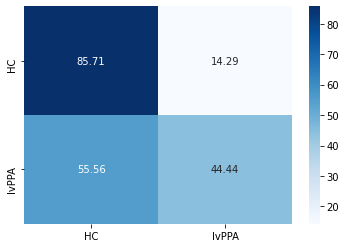

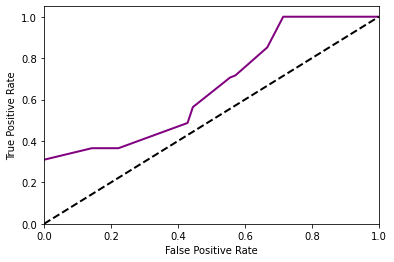

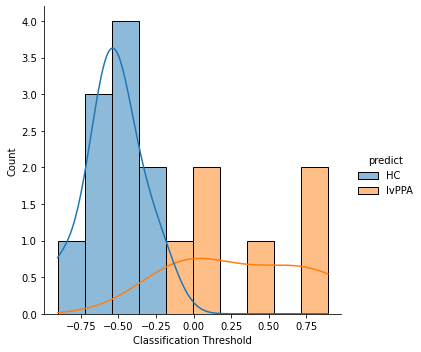

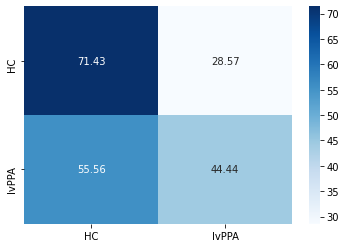

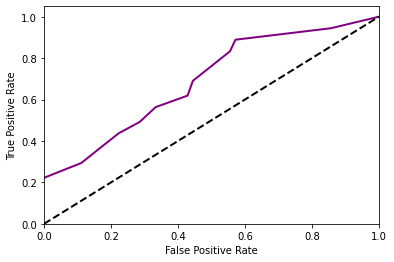

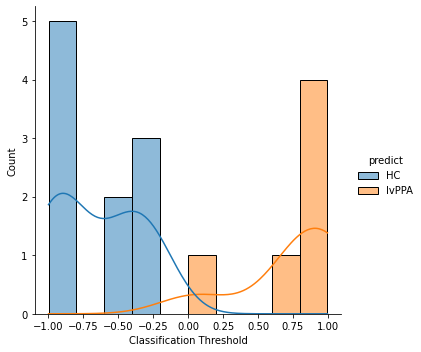

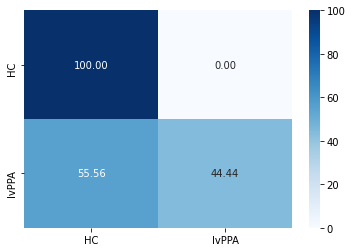

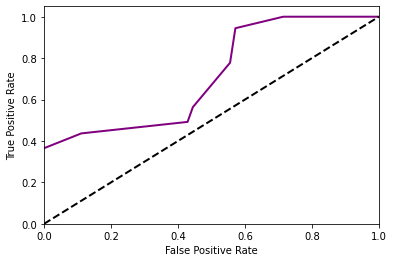

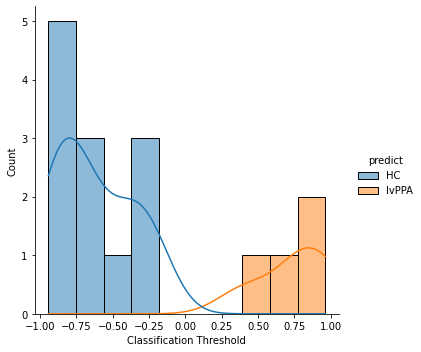

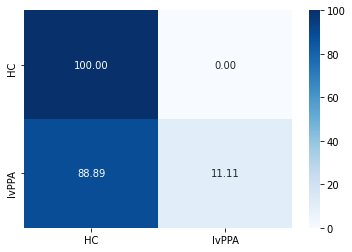

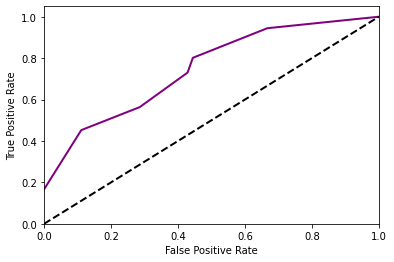

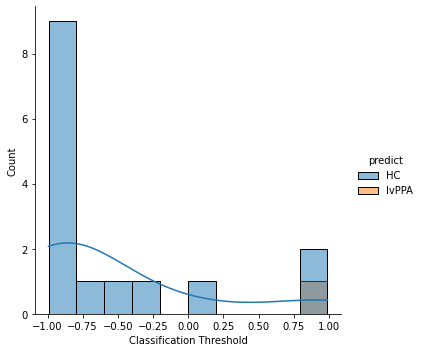

In [16]:
v1, v2 = 'HC', 'lvPPA'
train, test = get_train_test(data, v1, v2)
varimp = {}

x = morphosyntactic_fractions
y = 'variant'

algo = 'DRF'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
y_pred = np.full(predicted.shape[0], v2)
y_pred[predicted[v1][predicted[v1] >= 0.5].index] = v1
cm = confusion_matrix(test.as_data_frame()['variant'], y_pred, labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax, color='purple')
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], y_pred, labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], y_pred)

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'GLM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax, color='purple')
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'XGBoost'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax, color='purple')
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'GBM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax, color='purple')
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()

feature_importance = pd.DataFrame(index=morphosyntactic_fractions)
for algo in varimp.keys():
    feature_importance = feature_importance.join(pd.DataFrame(varimp[algo]).set_index(0)[2].rename(algo))
feature_importance.loc[:, 'mean'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values('mean', ascending=False)
feature_importance.to_csv('feature_importance_{}_{}_morpho.csv'.format(v1.lower(), v2.lower()))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:06:00.45: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 38.0.

███████████████████████████████████████████████████████████████| (don

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


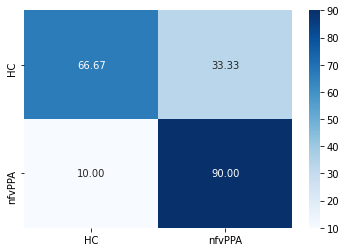

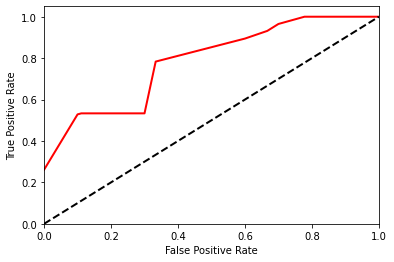

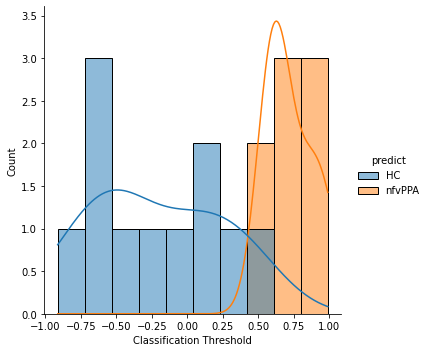

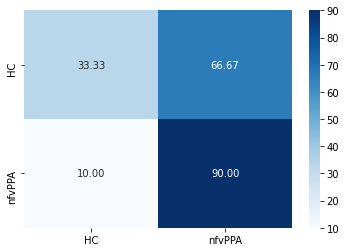

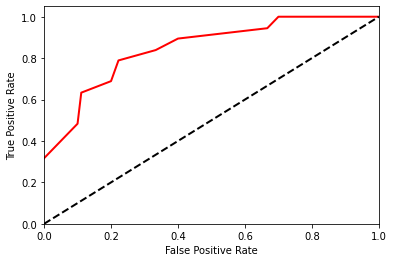

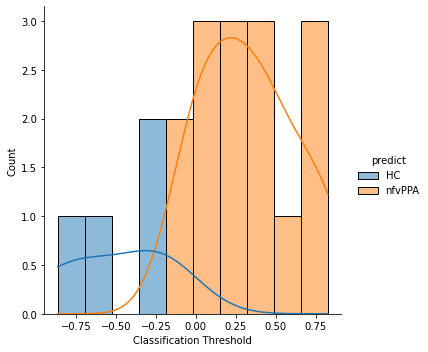

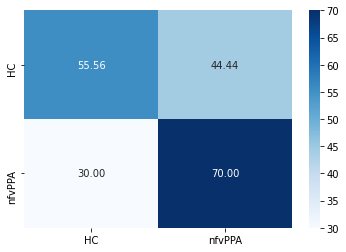

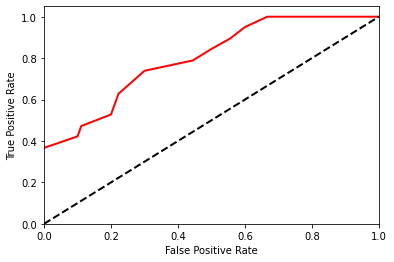

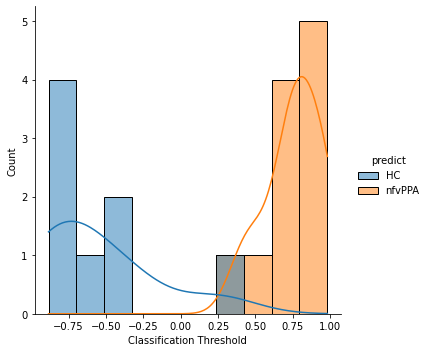

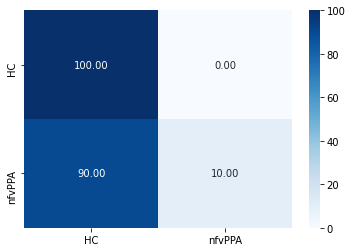

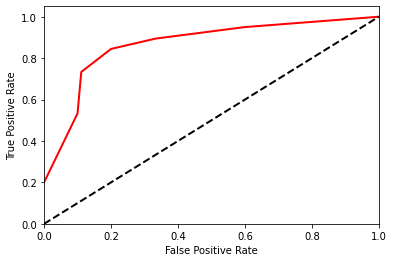

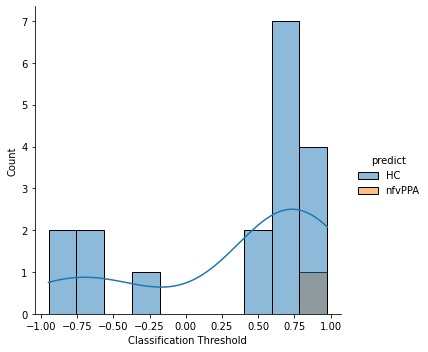

In [17]:
v1, v2 = 'HC', 'nfvPPA'
train, test = get_train_test(data, v1, v2)
varimp = {}

x = morphosyntactic_fractions

algo = 'DRF'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
y_pred = np.full(predicted.shape[0], v2)
y_pred[predicted[v1][predicted[v1] >= 0.5].index] = v1
cm = confusion_matrix(test.as_data_frame()['variant'], y_pred, labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax, color='red')
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], y_pred, labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], y_pred)

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'GLM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax, color='red')
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'XGBoost'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax, color='red')
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'GBM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax, color='red')
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()

feature_importance = pd.DataFrame(index=morphosyntactic_fractions)
for algo in varimp.keys():
    feature_importance = feature_importance.join(pd.DataFrame(varimp[algo]).set_index(0)[2].rename(algo))
feature_importance.loc[:, 'mean'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values('mean', ascending=False)
feature_importance.to_csv('feature_importance_{}_{}_morpho.csv'.format(v1.lower(), v2.lower()))

In [18]:
# v1, v2 = 'lvPPA', 'nfvPPA'
# train, test = get_train_test(data, v1, v2)

# algo = 'DRF'

# aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
# aml.train(x=x, y=y, training_frame=train)

# predicted = aml.predict(test).as_data_frame()
# cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
# ax.set_xticklabels(labels=[v1, v2])
# ax.set_yticklabels(labels=[v1, v2])
# fig.savefig('figures/confusion_matrices/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
# auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
# acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

# results.loc[results.shape[0]] = ['{}-{}'.format(v1, v2), algo, acc, precision, recall, auroc]


# algo = 'GLM'

# aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
# aml.train(x=x, y=y, training_frame=train)

# predicted = aml.predict(test).as_data_frame()
# cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
# ax.set_xticklabels(labels=[v1, v2])
# ax.set_yticklabels(labels=[v1, v2])
# fig.savefig('figures/confusion_matrices/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
# auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
# acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

# results.loc[results.shape[0]] = ['{}-{}'.format(v1, v2), algo, acc, precision, recall, auroc]


# algo = 'XGBoost'

# aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
# aml.train(x=x, y=y, training_frame=train)

# predicted = aml.predict(test).as_data_frame()
# cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
# ax.set_xticklabels(labels=[v1, v2])
# ax.set_yticklabels(labels=[v1, v2])
# fig.savefig('figures/confusion_matrices/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
# auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
# acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

# results.loc[results.shape[0]] = ['{}-{}'.format(v1, v2), algo, acc, precision, recall, auroc]


# algo = 'GBM'

# aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
# aml.train(x=x, y=y, training_frame=train)

# predicted = aml.predict(test).as_data_frame()
# cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
# fig, ax = plt.subplots(1, 1)
# sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
# ax.set_xticklabels(labels=[v1, v2])
# ax.set_yticklabels(labels=[v1, v2])
# fig.savefig('figures/confusion_matrices/{}_{}_{}.png'.format(v1.lower(), v2.lower(), algo.lower()))

# precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
# auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
# acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

# results.loc[results.shape[0]] = ['{}-{}'.format(v1, v2), algo, acc, precision, recall, auroc]

In [19]:
data = data.loc[data['variant'].isin(['lvPPA', 'nfvPPA'])].join(neuropsych.drop(columns=['variant']), how='inner')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:06:32.632: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 40.0.

███████████████████████████████████████████████████████████████| (do

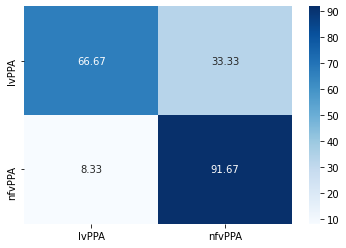

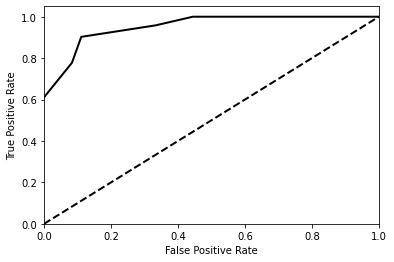

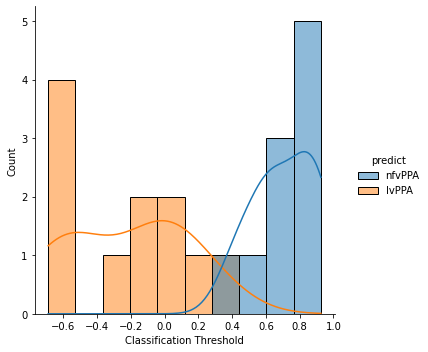

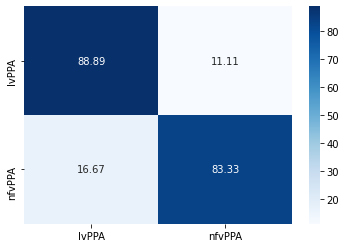

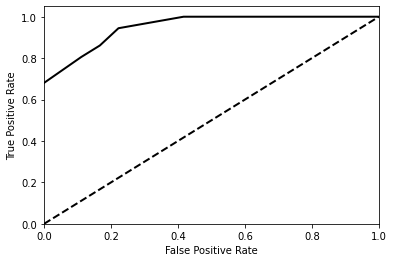

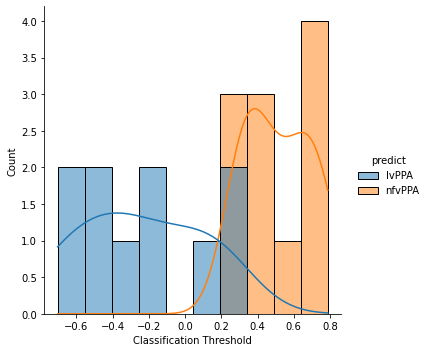

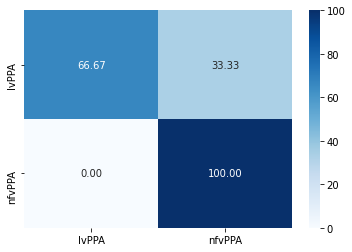

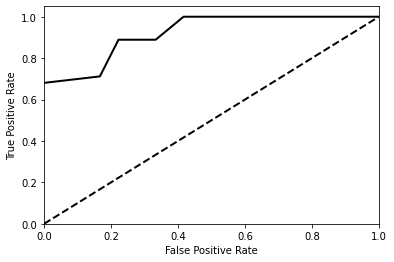

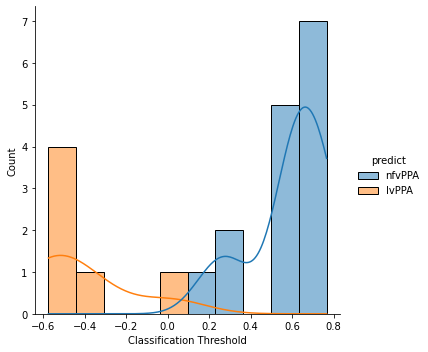

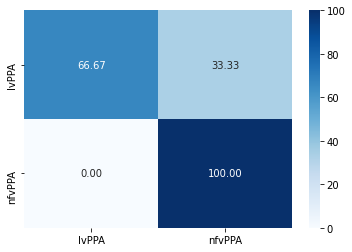

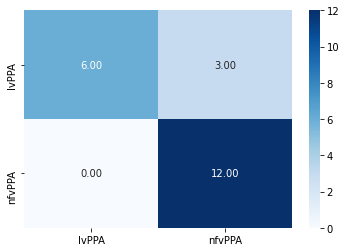

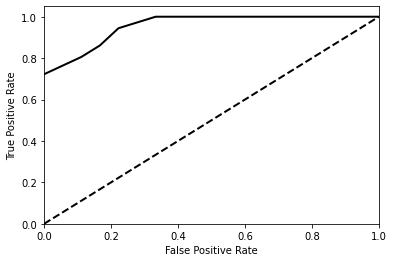

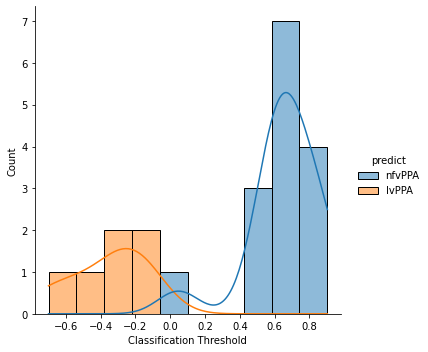

In [20]:
v1, v2 = 'lvPPA', 'nfvPPA'
train, test = get_train_test(data, v1, v2)
varimp = {}

x = morphosyntactic_fractions

algo = 'DRF'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
y_pred = np.full(predicted.shape[0], v2)
y_pred[predicted[v1][predicted[v1] >= 0.5].index] = v1
cm = confusion_matrix(test.as_data_frame()['variant'], y_pred, labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], y_pred, labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], y_pred)

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'GLM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'XGBoost'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'GBM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize=None)
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_morpho_raw.png'.format(v1.lower(), v2.lower(), algo.lower()))

y_true_morpho = test.as_data_frame()['variant']
y_pred_morpho = predicted['predict']

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_morpho.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Morphosyntax'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()

feature_importance = pd.DataFrame(index=morphosyntactic_fractions)
for algo in varimp.keys():
    feature_importance = feature_importance.join(pd.DataFrame(varimp[algo]).set_index(0)[2].rename(algo))
feature_importance.loc[:, 'mean'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values('mean', ascending=False)
feature_importance.to_csv('feature_importance_{}_{}_morpho.csv'.format(v1.lower(), v2.lower()))

In [21]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# transformed = scaler.fit_transform(predicted.loc[:, 'lvPPA':'nfvPPA'])
# roc_auc_score(test.as_data_Fanframe()['variant'], transformed[:, 1], labels=[v1, v2])
# (test.as_data_frame()['variant'] == 'lvPPA') == (predicted['lvPPA'] > 0.347)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:07:04.820: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 40.0.

███████████████████████████████████████████████████████████████| (do

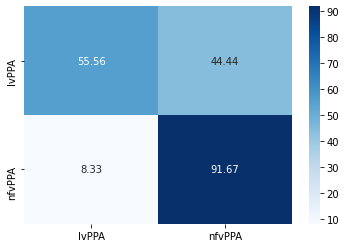

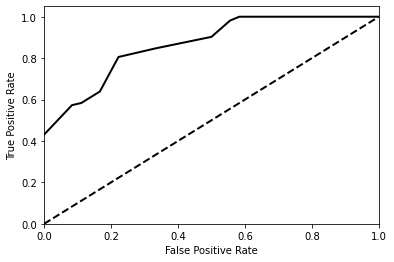

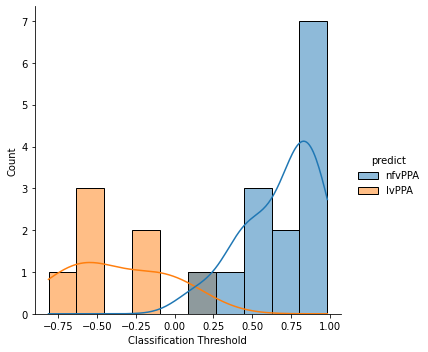

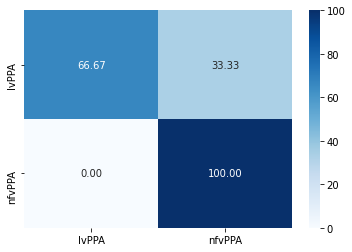

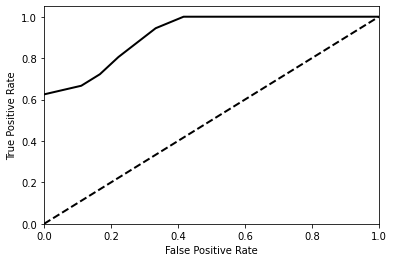

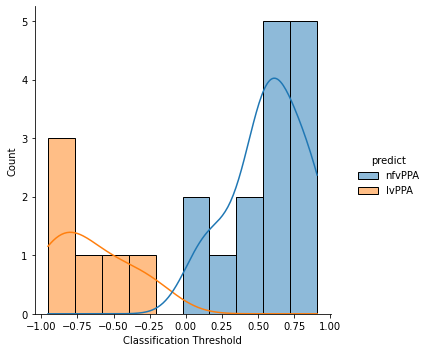

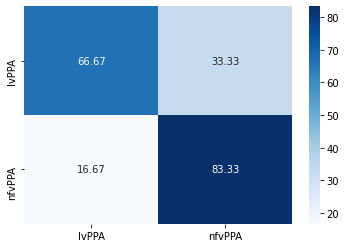

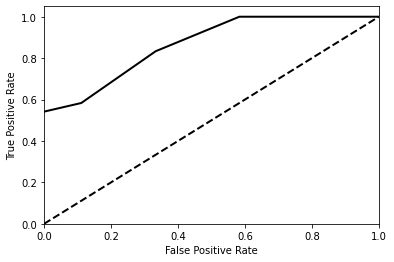

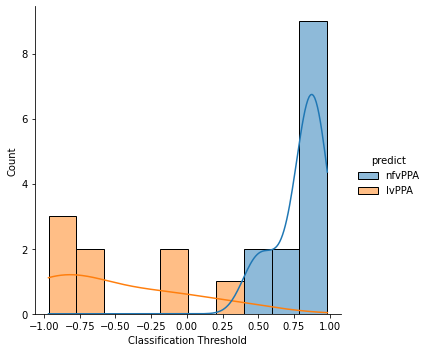

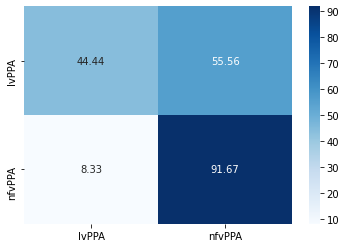

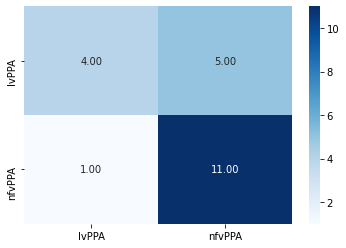

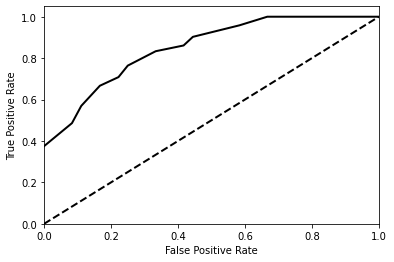

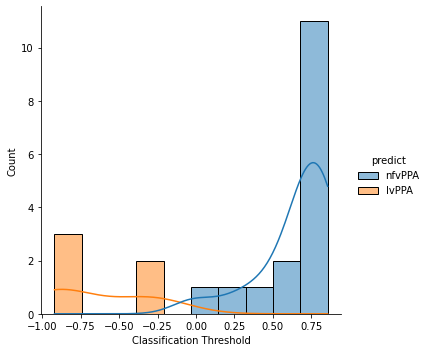

In [22]:
v1, v2 = 'lvPPA', 'nfvPPA'
train, test = get_train_test(data, v1, v2)
varimp = {}

x = neuropsych_features

algo = 'DRF'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
y_pred = np.full(predicted.shape[0], v2)
y_pred[predicted[v1][predicted[v1] >= 0.5].index] = v1
cm = confusion_matrix(test.as_data_frame()['variant'], y_pred, labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], y_pred, labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], y_pred)

results.loc[results.shape[0]] = ['{}-{}-Neuropsych'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'GLM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Neuropsych'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'XGBoost'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Neuropsych'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()


algo = 'GBM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize=None)
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_neuro_raw.png'.format(v1.lower(), v2.lower(), algo.lower()))

y_true_neuro = test.as_data_frame()['variant']
y_pred_neuro = predicted['predict']

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

predicted['difference'] = predicted[v2] - predicted[v1]
sns.displot(x='difference', hue='predict', data=predicted, bins=10, kde=True)
plt.xlabel('Classification Threshold')
plt.savefig('figures/score_distributions/{}_{}_{}_neuro.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Neuropsych'.format(v1, v2), algo, acc, precision, recall, auroc]
varimp[algo] = aml.leader.varimp()

feature_importance = pd.DataFrame(index=neuropsych_features)
for algo in varimp.keys():
    feature_importance = feature_importance.join(pd.DataFrame(varimp[algo]).set_index(0)[2].rename(algo))
feature_importance.loc[:, 'mean'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values('mean', ascending=False)
feature_importance.to_csv('feature_importance_{}_{}_neuro.csv'.format(v1.lower(), v2.lower()))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:07:40.540: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 40.0.

███████████████████████████████████████████████████████████████| (do

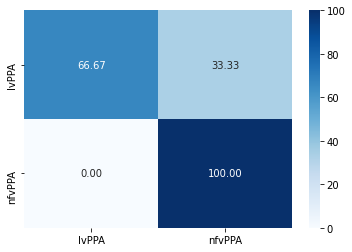

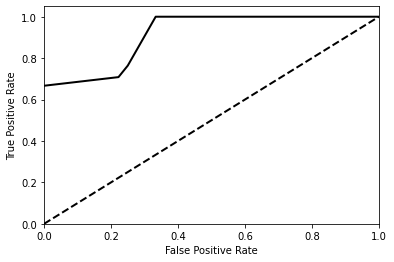

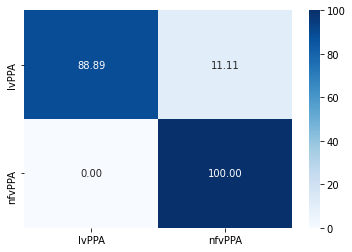

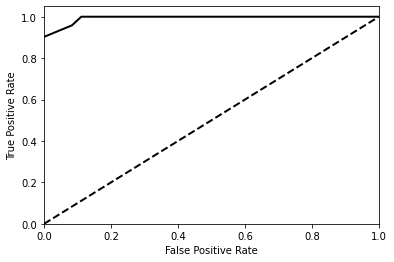

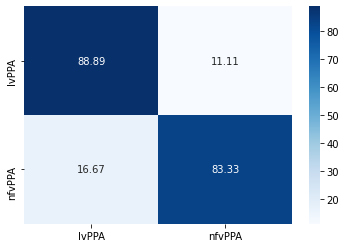

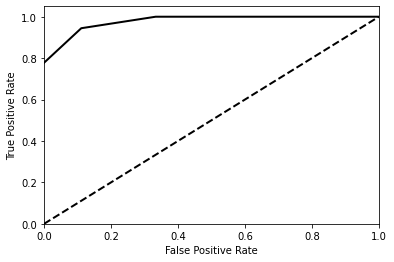

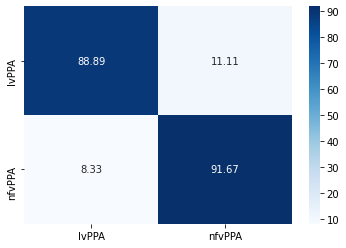

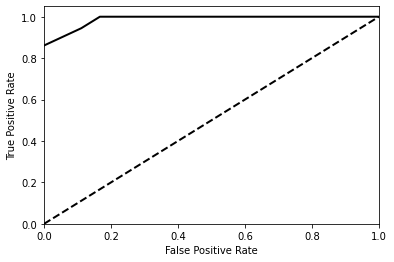

In [23]:
v1, v2 = 'lvPPA', 'nfvPPA'
train, test = get_train_test(data, v1, v2)

x = morphosyntactic_features + neuropsych_features


algo = 'DRF'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
y_pred = np.full(predicted.shape[0], v2)
y_pred[predicted[v1][predicted[v1] >= 0.5].index] = v1
cm = confusion_matrix(test.as_data_frame()['variant'], y_pred, labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_both.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_both.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Both'.format(v1, v2), algo, acc, precision, recall, auroc]


algo = 'GLM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_both.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_both.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Both'.format(v1, v2), algo, acc, precision, recall, auroc]


algo = 'XGBoost'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_both.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_both.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Both'.format(v1, v2), algo, acc, precision, recall, auroc]


algo = 'GBM'

aml = H2OAutoML(max_models=20, include_algos=[algo], seed=20)
aml.train(x=x, y=y, training_frame=train)

predicted = aml.predict(test).as_data_frame()
cm = confusion_matrix(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], normalize='true')
fig, ax = plt.subplots(1, 1)
sns.heatmap(cm * 100, cmap='Blues', annot=True, fmt='.02f', ax=ax)
ax.set_xticklabels(labels=[v1, v2])
ax.set_yticklabels(labels=[v1, v2])
fig.savefig('figures/confusion_matrices/{}_{}_{}_both.png'.format(v1.lower(), v2.lower(), algo.lower()))

fig, ax = plt.subplots()
skplt.metrics.plot_roc(test.as_data_frame()['variant'], predicted.loc[:, [v1, v2]], plot_micro=False, plot_macro=True, title='', ax=ax)
remove_lines(ax)
fig.savefig('figures/roc_curves/{}_{}_{}_both.png'.format(v1.lower(), v2.lower(), algo.lower()))

precision, recall, *_ = precision_recall_fscore_support(test.as_data_frame()['variant'], predicted['predict'], labels=[v1, v2], average='weighted')
auroc = roc_auc_score(test.as_data_frame()['variant'], predicted.loc[:, [v2]], labels=[v1, v2])
acc = accuracy_score(test.as_data_frame()['variant'], predicted['predict'])

results.loc[results.shape[0]] = ['{}-{}-Both'.format(v1, v2), algo, acc, precision, recall, auroc]

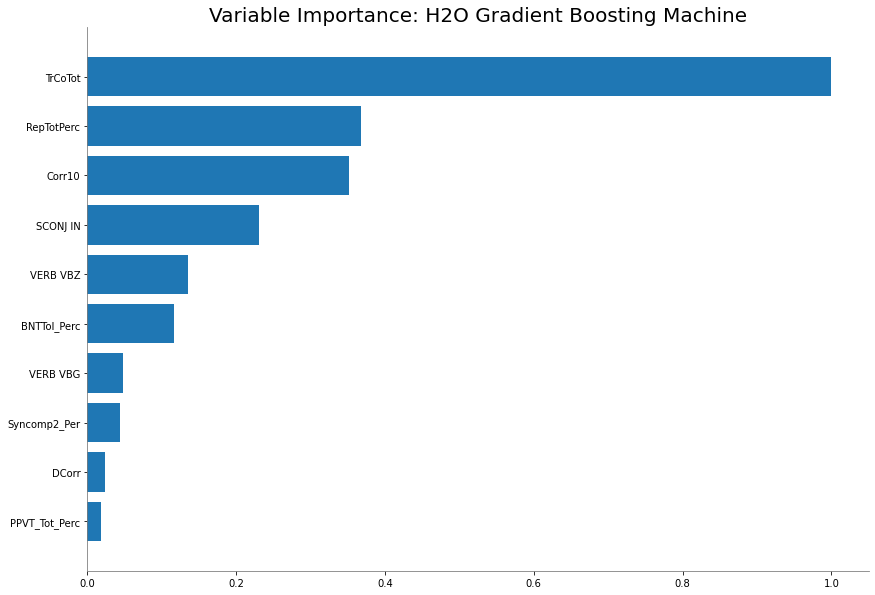

<Figure size 432x288 with 0 Axes>

In [24]:
aml.leader.varimp_plot()

In [25]:
# results.to_csv('results.csv')

In [34]:
((y_true_morpho == y_pred_morpho) & (y_true_neuro == y_pred_neuro)).sum()

13

In [35]:
((y_true_morpho == y_pred_morpho) & (y_true_neuro != y_pred_neuro)).sum()

5

In [36]:
((y_true_morpho != y_pred_morpho) & (y_true_neuro == y_pred_neuro)).sum()

2

In [37]:
((y_true_morpho != y_pred_morpho) & (y_true_neuro != y_pred_neuro)).sum()

1

In [38]:
from statsmodels.stats.contingency_tables import mcnemar

In [44]:
print(mcnemar([[13, 5], [2, 1]], exact=False))

pvalue      0.4496917979688908
statistic   0.5714285714285714
